In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
from rich.progress import track
from dataclasses import dataclass

In [11]:
class Dataset:
    def __init__(self, xk, yk):
        self.xk = xk
        self.yk = yk
        
    def affichage(self, repere, couleur="red"):
        repere.scatter(self.xk, self.yk, color=couleur, label="échantillon")



In [12]:
class Modele:
    def __init__(self, L):
        self.L = L
        
    def __call__(self, xs) -> float:
        return np.sin(10 * np.pi * xs / self.L) / (1 + np.exp(3 * xs / self.L))
    
    def affichage(self, repere, couleur="blue"):
        xs = np.linspace(0, self.L, 500)
        ys = self(xs)
        repere.plot(xs, ys, label="cible", color=couleur)

    def ds_simpliste(self, N: int) -> Dataset:
        xk = np.linspace(0, self.L, N+1)
        yk = self(xk)
        return Dataset(xk=xk, yk=yk)

    def ds_simple(self, N: int, epsilon: float) -> Dataset:
        xk = np.linspace(0, self.L, N+1)
        yk = self(xk) + epsilon * np.random.randn(N+1)
        return Dataset(xk=xk, yk=yk)

    def ds_raisonnable(self, N: int, epsilon: float) -> Dataset:
        xk = np.random.uniform(low=0., high=self.L, size=(N+1, ))
        yk = self(xk) + epsilon * np.random.randn(N+1)
        return Dataset(xk=xk, yk=yk)



In [13]:
class Gaussienne:
    def __init__(self, degre: int, L: float):
        if degre < 0:
            raise ValueError("Le degré doit ^etre positif")
        self.degre = degre
        self.coefficients = np.zeros(shape=(degre+1, ))
        self.L = L
        self.points = np.linspace(0, L, degre+1)
        self.phi = lambda x: np.exp(-(x * degre / L) ** 2)
        
    def __call__(self, x):
        return sum(
            coef * self.phi(x - point) 
            for coef, point in zip(self.coefficients, self.points)
        )
        
    def affichage(self, repere, couleur="magenta"):
        xs = np.linspace(0, self.L, 500)
        ys = self(xs)
        repere.plot(xs, ys, label="prédicteur", color=couleur)
        
    def erreur_quadratique(self, ds: Dataset) -> float:
        return np.sum((self(ds.xk) - ds.yk)**2) / len(ds.xk)
    
    def entrainement(self, ds: Dataset):
        def a_minimiser(cs):
            self.coefficients = cs
            return self.erreur_quadratique(ds)
        
        opti_result = minimize(
            fun=a_minimiser,
            x0=self.coefficients,
        )
        if not opti_result.success:
            print("Entrainement Sans succès",)
            print(opti_result.message)
        self.coefficients = opti_result.x


In [8]:
def train_test_split(ds: Dataset, proportion=0.7) -> tuple[Dataset, Dataset]:
    xtest, ytest, xtrain, ytrain = list(), list(), list(), list()
    for x, y in zip(ds.xk, ds.yk):
        if np.random.random() < proportion:
            xtrain.append(x)
            ytrain.append(y)
        else:
            xtest.append(x)
            ytest.append(y)
    return Dataset(xtrain, ytrain), Dataset(xtest, ytest)




erreur training: 0.002713748172837903
erreur_test    : 0.3450667470570821



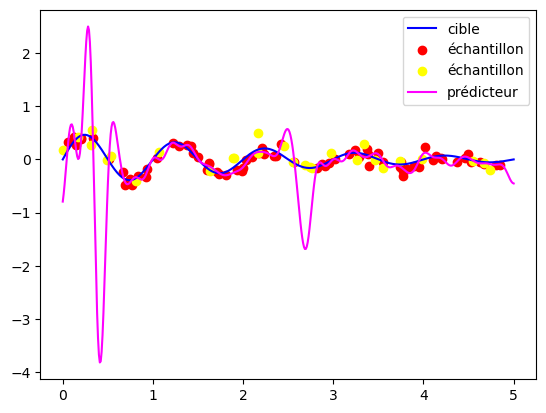

In [10]:
mod = Modele(L=5.)
ds = mod.ds_raisonnable(100, 0.1)
dstrain, dstest = train_test_split(ds)

fig,rep = plt.subplots()

mod.affichage(rep)
dstrain.affichage(rep, "red")
dstest.affichage(rep, "yellow")

gauss = Gaussienne(degre=50, L=mod.L)
gauss.entrainement(dstrain)
gauss.affichage(rep)
rep.legend()

print(f"""
erreur training: {gauss.erreur_quadratique(dstrain)}
erreur_test    : {gauss.erreur_quadratique(dstest)}
""")


- On constate que la courbe magenta est fortement différente de la courbe bleu par endroit.
- C'est un symptome de surapprentissage.
- Cela est confirmé par la différence d'un facteur 150 entre l'erreur sur l'échantillon d'apprentissage et l'erreur sur l'échantillon de test.
- L'avantage est que dans le monde réel on aura juste accès à l'échantillon pas au modèle caché qui l'a "*généré*"

**EXERCICE** 

Générer une figure contenant les graphes d'erreur sur échantillon de test et échantillon d'entrainement avec en abcisse le degré de complexité du modèle.

In [21]:
%%time
L = 5.
taille_echantillon = 100
degre_max = 50

mod = Modele(L=L)

ds = mod.ds_raisonnable(N=taille_echantillon, epsilon=0.1)
ds_train, ds_test = train_test_split(ds)

erreurs_train, erreurs_test = list(), list()
degres = list(range(10, degre_max))

for degre in degres:
    gaussien = Gaussienne(degre=degre, L=L)
    gaussien.entrainement(ds_train)
    erreurs_train.append(gaussien.erreur_quadratique(ds_train))
    erreurs_test.append(gaussien.erreur_quadratique(ds_test))
    

CPU times: user 1min 4s, sys: 4 ms, total: 1min 4s
Wall time: 1min 4s


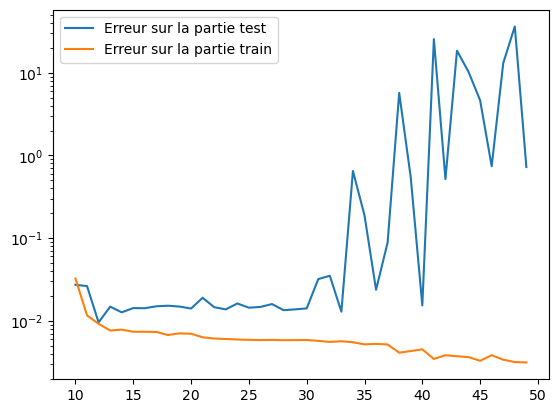

In [22]:
fig, rep = plt.subplots()

rep.semilogy(degres, erreurs_test, label="Erreur sur la partie test")
rep.semilogy(degres, erreurs_train, label="Erreur sur la partie train")
rep.legend()

Visuellement on s'attend à du surapprentissage à partir du degré 30.

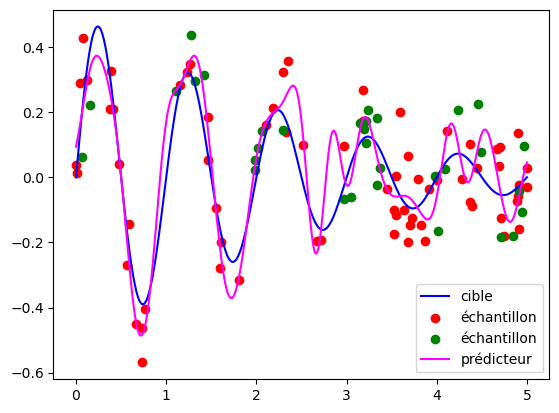

In [24]:
gauss = Gaussienne(degre=30, L=5.)
gauss.entrainement(ds)

fig,rep = plt.subplots()

mod.affichage(repere=rep)
ds_train.affichage(repere=rep, couleur="red")
ds_test.affichage(repere=rep, couleur="green")
gauss.affichage(repere=rep)
rep.legend()

**EXERCICE** Faite le meme graphe mais cette fois ci c'est la taille du dataset qui change et qui est en abcisse.

In [25]:
%%time
L = 5.
degre_fixe = 50
taille_min, taille_max = 50, 201

tailles = list(range(taille_min, taille_max, 5))
mod = Modele(L=L)



erreurs_train, erreurs_test = list(), list()

for taille in tailles:
    ds = mod.ds_raisonnable(N=taille, epsilon=0.1)
    ds_train, ds_test = train_test_split(ds)
    gaussien = Gaussienne(degre=degre_fixe, L=L)
    gaussien.entrainement(ds_train)
    erreurs_train.append(gaussien.erreur_quadratique(ds_train))
    erreurs_test.append(gaussien.erreur_quadratique(ds_test))
    

CPU times: user 2min 28s, sys: 10 ms, total: 2min 28s
Wall time: 2min 28s


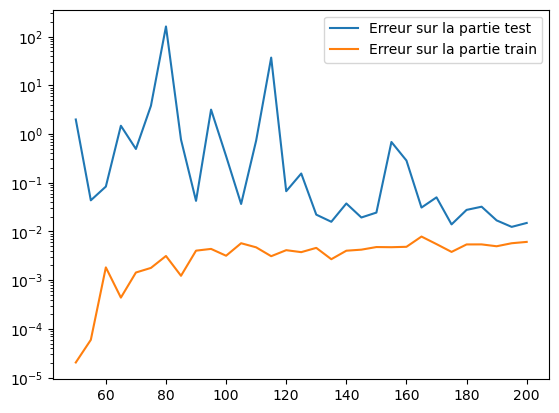

In [26]:
fig, rep = plt.subplots()

rep.semilogy(tailles, erreurs_test, label="Erreur sur la partie test")
rep.semilogy(tailles, erreurs_train, label="Erreur sur la partie train")
rep.legend()

On voit que à complexité fixé, plus de données implique moins de surapprentissage.

**EXERCICE** Plutot que d'utiliser `minimize` utiliser `least_squares` qui est à priori mieux adapter au problème.

In [28]:
class GaussienneV2:
    def __init__(self, degre: int, L: float):
        if degre < 0:
            raise ValueError("Le degré doit ^etre positif")
        self.degre = degre
        self.coefficients = np.zeros(shape=(degre+1, ))
        self.L = L
        self.points = np.linspace(0, L, degre+1)
        self.phi = lambda x: np.exp(-(x * degre / L) ** 2)
        
    def __call__(self, x):
        return sum(
            coef * self.phi(x - point) 
            for coef, point in zip(self.coefficients, self.points)
        )
        
    def affichage(self, repere, couleur="magenta"):
        xs = np.linspace(0, self.L, 500)
        ys = self(xs)
        repere.plot(xs, ys, label="prédicteur", color=couleur)
        
    def erreur_quadratique(self, ds: Dataset) -> float:
        return np.sum((self(ds.xk) - ds.yk)**2) / len(ds.xk)
    
    def entrainement(self, ds: Dataset):
        def calcule_residus(cs):
            self.coefficients = cs
            return self(ds.xk) - ds.yk
        
        opti_result = least_squares(
            fun=calcule_residus,
            x0=self.coefficients,
        )
        if not opti_result.success:
            print("Entrainement Sans succès",)
            print(opti_result.message)
        self.coefficients = opti_result.x

In [29]:
%%time
L = 5.
taille_echantillon = 100
degre_max = 50

mod = Modele(L=L)

ds = mod.ds_raisonnable(N=taille_echantillon, epsilon=0.1)
ds_train, ds_test = train_test_split(ds)

erreurs_train, erreurs_test = list(), list()
degres = list(range(10, degre_max))

for degre in degres:
    gaussien = GaussienneV2(degre=degre, L=L)
    gaussien.entrainement(ds_train)
    erreurs_train.append(gaussien.erreur_quadratique(ds_train))
    erreurs_test.append(gaussien.erreur_quadratique(ds_test))
    

CPU times: user 1.88 s, sys: 2 ms, total: 1.88 s
Wall time: 1.9 s


On voit que choisir un solveur adapté est clef pour avoir une performance de qualité.

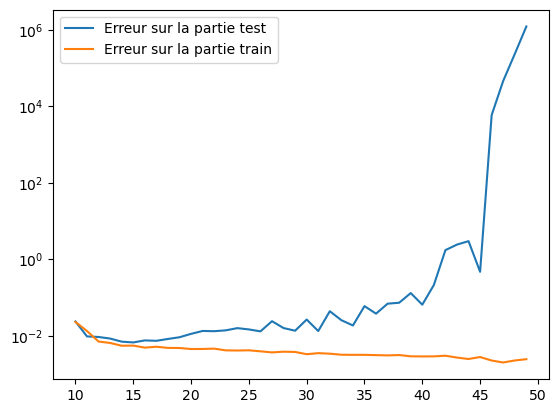

In [30]:
fig, rep = plt.subplots()

rep.semilogy(degres, erreurs_test, label="Erreur sur la partie test")
rep.semilogy(degres, erreurs_train, label="Erreur sur la partie train")
rep.legend()

**EXERCICE** utiliser de manière appropriée le paramètre `jac` de la fonction `least_squares`.

In [34]:
class GaussienneV3:
    def __init__(self, degre: int, L: float):
        if degre < 0:
            raise ValueError("Le degré doit ^etre positif")
        self.degre = degre
        self.coefficients = np.zeros(shape=(degre+1, ))
        self.L = L
        self.points = np.linspace(0, L, degre+1)
        self.phi = lambda x: np.exp(-(x * degre / L) ** 2)
        
    def __call__(self, x):
        return sum(
            coef * self.phi(x - point) 
            for coef, point in zip(self.coefficients, self.points)
        )
        
    def affichage(self, repere, couleur="magenta"):
        xs = np.linspace(0, self.L, 500)
        ys = self(xs)
        repere.plot(xs, ys, label="prédicteur", color=couleur)
        
    def erreur_quadratique(self, ds: Dataset) -> float:
        return np.sum((self(ds.xk) - ds.yk)**2) / len(ds.xk)
    
    def entrainement(self, ds: Dataset):
        def calcule_residus(cs):
            self.coefficients = cs
            return self(ds.xk) - ds.yk
        
        def calcule_jac(cs):
            tableau = [
                [
                  self.phi(xi - betaj)
                    for betaj in self.points
                ]
                for xi in ds.xk
            ]
            return np.array(tableau)
        
        opti_result = least_squares(
            fun=calcule_residus,
            jac=calcule_jac,
            x0=self.coefficients,
        )
        if not opti_result.success:
            print("Entrainement Sans succès",)
            print(opti_result.message)
        self.coefficients = opti_result.x

In [35]:
%%time
L = 5.
taille_echantillon = 100
degre_max = 50

mod = Modele(L=L)

ds = mod.ds_raisonnable(N=taille_echantillon, epsilon=0.1)
ds_train, ds_test = train_test_split(ds)

erreurs_train, erreurs_test = list(), list()
degres = list(range(10, degre_max))

for degre in degres:
    gaussien = GaussienneV3(degre=degre, L=L)
    gaussien.entrainement(ds_train)
    erreurs_train.append(gaussien.erreur_quadratique(ds_train))
    erreurs_test.append(gaussien.erreur_quadratique(ds_test))
    
fig, rep = plt.subplots()

rep.semilogy(degres, erreurs_test, label="Erreur sur la partie test")
rep.semilogy(degres, erreurs_train, label="Erreur sur la partie train")
rep.legend()

CPU times: user 388 ms, sys: 0 ns, total: 388 ms
Wall time: 387 ms


In [37]:
%%time
L = 5.
taille_echantillon = 200
degre_max = 100

mod = Modele(L=L)

ds = mod.ds_raisonnable(N=taille_echantillon, epsilon=0.1)
ds_train, ds_test = train_test_split(ds)

erreurs_train, erreurs_test = list(), list()
degres = list(range(10, degre_max, 2))

for degre in degres:
    gaussien = GaussienneV3(degre=degre, L=L)
    gaussien.entrainement(ds_train)
    erreurs_train.append(gaussien.erreur_quadratique(ds_train))
    erreurs_test.append(gaussien.erreur_quadratique(ds_test))
    
fig, rep = plt.subplots()

rep.semilogy(degres, erreurs_test, label="Erreur sur la partie test")
rep.semilogy(degres, erreurs_train, label="Erreur sur la partie train")
rep.legend()

CPU times: user 2.15 s, sys: 1e+03 ns, total: 2.15 s
Wall time: 2.15 s


CPU times: user 11.7 s, sys: 0 ns, total: 11.7 s
Wall time: 11.7 s


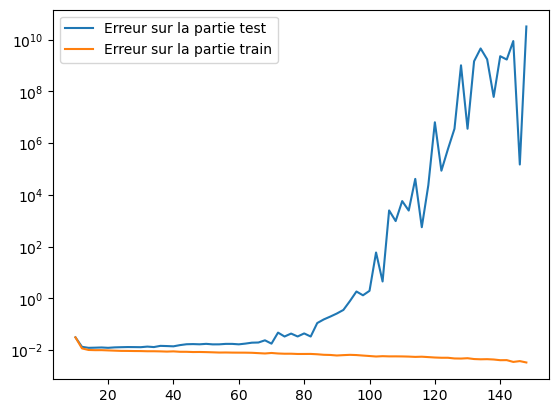

In [39]:
%%time
L = 5.
taille_echantillon = 300
degre_max = 150

mod = Modele(L=L)

ds = mod.ds_raisonnable(N=taille_echantillon, epsilon=0.1)
ds_train, ds_test = train_test_split(ds)

erreurs_train, erreurs_test = list(), list()
degres = list(range(10, degre_max, 2))

for degre in degres:
    gaussien = GaussienneV3(degre=degre, L=L)
    gaussien.entrainement(ds_train)
    erreurs_train.append(gaussien.erreur_quadratique(ds_train))
    erreurs_test.append(gaussien.erreur_quadratique(ds_test))
    
fig, rep = plt.subplots()

rep.semilogy(degres, erreurs_test, label="Erreur sur la partie test")
rep.semilogy(degres, erreurs_train, label="Erreur sur la partie train")
rep.legend()

**EXERCICE** Implémenter vous meme la solution en utilisant le fait que les résidus sont linéaires par rapport aux coefficients du modèle. On n'utilise plus `least_squares`.

**EXERCICE** Proposer un modèle alternatif où on peut préciser au moment de la construction la fonction correspondant précédemment à la gaussienne. Et explorer d'autres modèles.

**REMARQUE** On a utilisé à ce stade la partie test de l'échantillon pour estimer l'hyperparamètre correspondant à la complexité du modèle.
Ce qui veut dire que l'on n'a plus rien pour tester si ce "meilleur modèle" issu d'une sorte de méta-apprentissage est en surapprentissage  ou pas.

Il faut une autre façon de garantir ce modèle.

**EXERCICE** Faites une procédure où vous découper en trois l'échantillon

1. Une partie sera utilisée à la fin sur un seul modèle pour garantir l'absence de surapprentissage.
2. Une partie sera utilisée pour déterminer le meilleur hyperparamètre dans une sorte de méta-apprentissage en force brute
3. Le reste sera utilisé pour la partie apprentissage elle meme.

In [40]:
L = 5.
taille_echantillon = 200

mod = Modele(L=L)
ds = mod.ds_raisonnable(N=taille_echantillon, epsilon=0.1)

In [41]:
ds_reste, ds_test = train_test_split(ds, proportion=0.8)
ds_train, ds_select = train_test_split(ds_reste, proportion=0.8)

In [50]:
@dataclass
class Score:
    degre: int
    score_entrainement: float
    score_selection: float

In [52]:
%%time
scores = list()

for degre in range(10, 100, 3):
    gaussienne = GaussienneV3(degre=degre, L=L)
    gaussienne.entrainement(ds_train)
    
    scores.append(
        Score(
            degre=degre, 
            score_entrainement=gaussienne.erreur_quadratique(ds_train),
            score_selection=gaussienne.erreur_quadratique(ds_select)
        )
    )
    

CPU times: user 2.24 s, sys: 1e+03 ns, total: 2.24 s
Wall time: 2.24 s


In [53]:
meilleur = min(scores, key=lambda s: s.score_selection)

In [54]:
meilleur

Score(degre=16, score_entrainement=0.009695474777186582, score_selection=0.01254142123041969)

In [55]:
gaussienne = GaussienneV3(degre=meilleur.degre, L=L)
gaussienne.entrainement(ds_reste)
print(f"""
Meilleur modèle
erreur training: {gaussienne.erreur_quadratique(ds_reste)}
erreur_test    : {gaussienne.erreur_quadratique(ds_test)}
""")



Meilleur modèle
erreur training: 0.009995365208924804
erreur_test    : 0.01462703408577077



Ce modèle ne semble pas en surapprentissage.

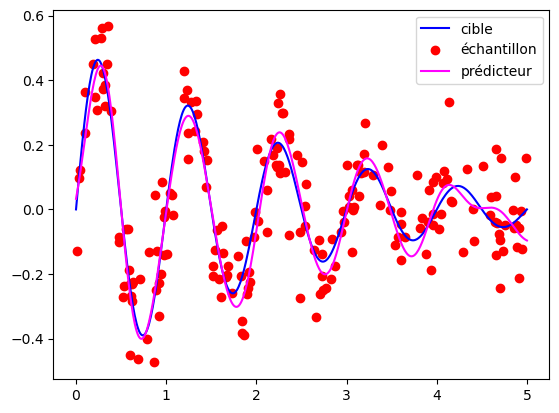

In [57]:
fig, rep = plt.subplots()

mod.affichage(rep)
ds.affichage(rep)
gaussienne.affichage(rep)
rep.legend()